In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
import random as rn
import iso_forest as iso
import seaborn as sb
import time
sb.set_style(style="whitegrid")
sb.set_color_codes()

/Users/sahand/anaconda/envs/python2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


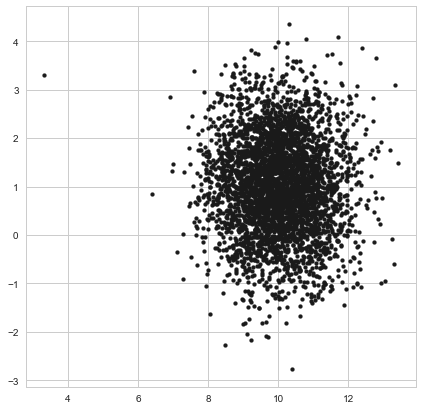

In [2]:
mean = [10, 1]
cov = [[1, 0], [0, 1]]  # diagonal covariance
Nobjs = 4000
x, y = np.random.multivariate_normal(mean, cov, Nobjs).T
#Add manual outlier
x[0]=3.3
y[0]=3.3
X=np.array([x,y]).T
plt.figure(figsize=(7,7))
plt.scatter(x,y,s=15,facecolor='k',edgecolor='k')

In [3]:
Forest1 = iso.iForest(X,ntrees=800, sample_size=256)
S = Forest1.compute_paths(X)

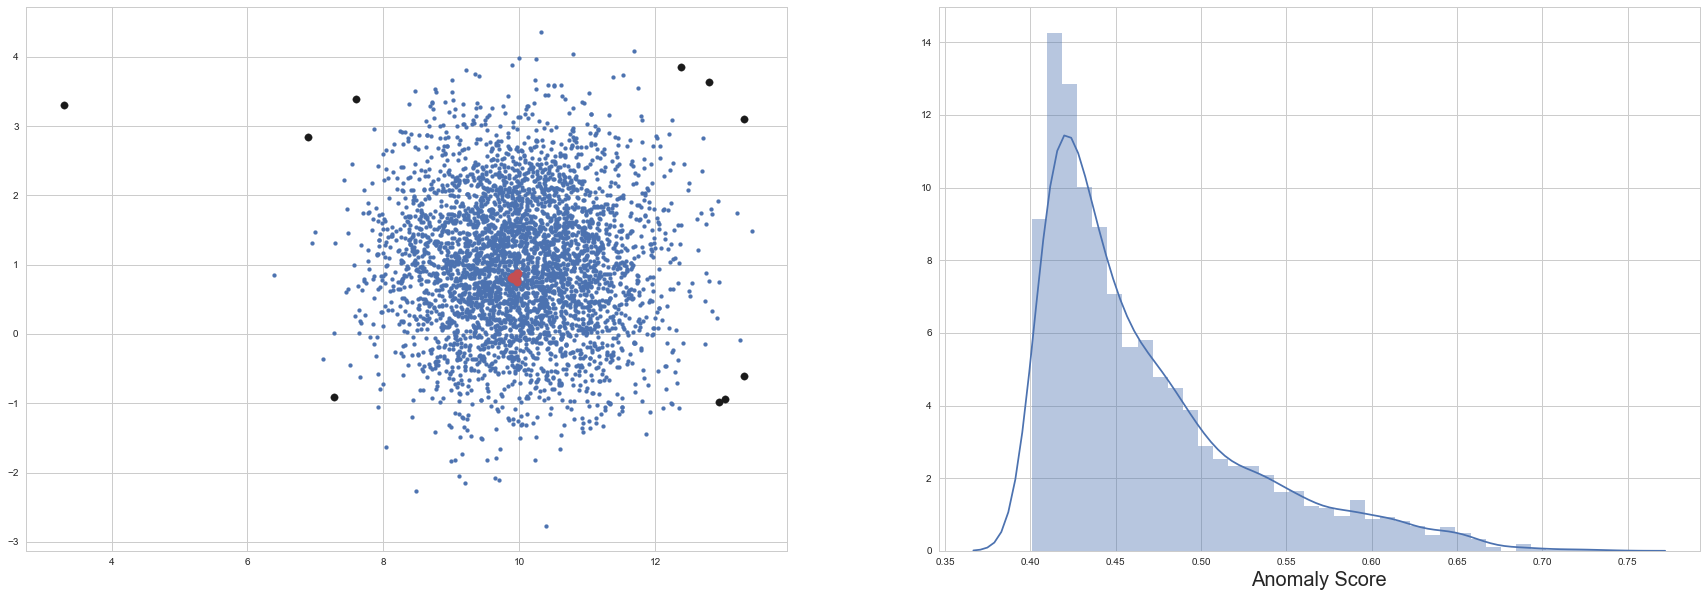

In [4]:
plt.rcParams['figure.figsize'] = (30, 10)
plt.figure()
plt.subplot(1,2,2)
p=sb.distplot(S, kde=True, color="b")
plt.xlabel('Anomaly Score',fontsize=20)
plt.subplot(1,2,1)
ss=np.argsort(S)
plt.scatter(x,y,s=15,c='b',edgecolor='b')
plt.scatter(x[ss[-10:]],y[ss[-10:]],s=55,c='k')
plt.scatter(x[ss[:10]],y[ss[:10]],s=55,c='r')
plt.savefig("/Users/sahand/Research/iso_forest/report/images/iso_forest.png",bbox_inches='tight')

# [Case 1] Create 800 trees in a single core

In [5]:
ForestAssemblyTimes1 = []
ComputeScoreTimes1   = []

### Train and Score

In [6]:
 for i in range(5):
    t1 = time.time()
    Forest1 = iso.iForest(X,ntrees=800, sample_size=256)
    t2 = time.time()
    ForestAssemblyTimes1.append(t2-t1)
    
    t1 = time.time()
    S1 = Forest1.compute_paths(X)
    t2 = time.time()
    ComputeScoreTimes1.append(t2-t1)

In [7]:
print("assembly mean: ",np.mean(ForestAssemblyTimes1))
print("assembly var: " ,np.var(ForestAssemblyTimes1))
print ("="*40)
print("score mean: ",np.mean(ComputeScoreTimes1))
print("score var: " ,np.var(ComputeScoreTimes1))

('assembly mean: ', 2.9634642124176027)
('assembly var: ', 0.056633665259992083)
('score mean: ', 62.244374752044678)
('score var: ', 2.3131722844104159)


### Visualize

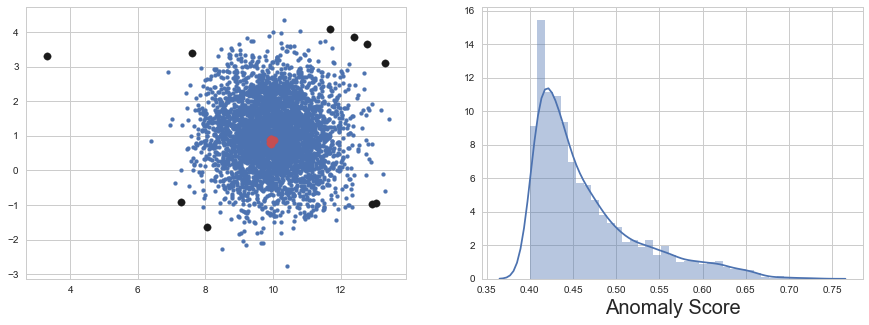

In [8]:
plt.rcParams['figure.figsize'] = (15, 5)
plt.figure()
plt.subplot(1,2,2)
p=sb.distplot(S1, kde=True, color="b")
plt.xlabel('Anomaly Score',fontsize=20)
plt.subplot(1,2,1)
ss=np.argsort(S1)
plt.scatter(x,y,s=15,c='b',edgecolor='b')
plt.scatter(x[ss[-10:]],y[ss[-10:]],s=55,c='k')
plt.scatter(x[ss[:10]],y[ss[:10]],s=55,c='r')

# [Case 2] Create 100 trees in 8 cores. Each core has access to the full data set. 

In [53]:
ForestAssemblyTimes2 = []
ComputeScoreTimes2   = []

### Train and Score

In [84]:
Y = X[:,:]
for i in range(1):
    t1 = time.time()

    myrdd = sc.parallelize(X)
    Forest2 = myrdd.map(lambda x: iso.iForest(x,ntrees=100, sample_size=256))
    t2 = time.time()
    ForestAssemblyTimes2.append(t2-t1)
    
    #t1  = time.time()
    #S_t = Forest2.map(lambda F: F.compute_paths(X))
    #S2  = S_t.reduce(lambda a,b: a+b)/8
    #t2  = time.time()
    #ComputeScoreTimes2.append(t2-t1)

In [60]:
print("assembly mean: ",np.mean(ForestAssemblyTimes2))
print("assembly var: " ,np.var(ForestAssemblyTimes2))
print ("="*40)
print("score mean: ",np.mean(ComputeScoreTimes2))
print("score var: " ,np.var(ComputeScoreTimes2))

('assembly mean: ', 0.0065386295318603516)
('assembly var: ', 3.6671078381308084e-06)
('score mean: ', 6.6387036323547362)
('score var: ', 0.10150891603410402)


### Visualize

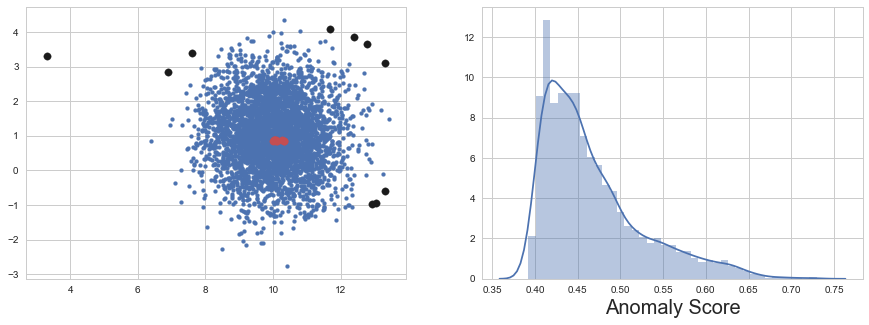

In [55]:
plt.rcParams['figure.figsize'] = (15, 5)
plt.figure()
plt.subplot(1,2,2)
p=sb.distplot(S2, kde=True, color="b")
plt.xlabel('Anomaly Score',fontsize=20)
plt.subplot(1,2,1)
ss=np.argsort(S2)
plt.scatter(x,y,s=15,c='b',edgecolor='b')
plt.scatter(x[ss[-10:]],y[ss[-10:]],s=55,c='k')
plt.scatter(x[ss[:10]],y[ss[:10]],s=55,c='r')

# [Case 3] Split the data for training among 8 cores. Each core has 100 trees

In [13]:
ForestAssemblyTimes3 = []
ComputeScoreTimes3   = []

### Helper Functions

In [14]:
def partition(l,n):
 return [l[i:i+n] for i in xrange(0,len(l),n)]

### Create Forest(s)

In [15]:
for i in range(5):
    t1 = time.time()
    data = sc.parallelize(partition(X,len(X)/8))
    Forest3 = data.map(lambda x: iso.iForest(x,ntrees=100, sample_size=256))
    t2 = time.time()
    ForestAssemblyTimes3.append(t2-t1)
    
    t1 = time.time()
    S_t = Forest3.map(lambda F: F.compute_paths(X))
    S3  = S_t.reduce(lambda a,b: a+b)/8
    t2 = time.time()
    ComputeScoreTimes3.append(t2-t1)

In [16]:
print("assembly mean: ",np.mean(ForestAssemblyTimes3))
print("assembly var: " ,np.var(ForestAssemblyTimes3))
print ("="*40)
print("score mean: ",np.mean(ComputeScoreTimes3))
print("score var: " ,np.var(ComputeScoreTimes3))

('assembly mean: ', 0.0070830821990966793)
('assembly var: ', 1.3786109229840804e-06)
('score mean: ', 15.842739152908326)
('score var: ', 0.31556480375375939)


### Visualize

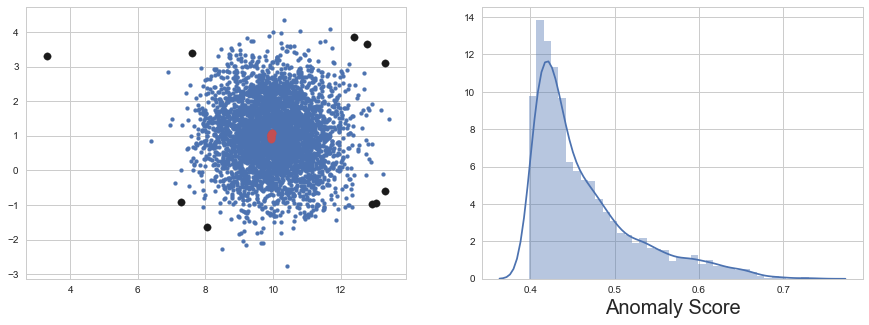

In [17]:
plt.rcParams['figure.figsize'] = (15, 5)
plt.figure()
plt.subplot(1,2,2)
p=sb.distplot(S3, kde=True, color="b")
plt.xlabel('Anomaly Score',fontsize=20)
plt.subplot(1,2,1)
ss=np.argsort(S3)
plt.scatter(x,y,s=15,c='b',edgecolor='b')
plt.scatter(x[ss[-10:]],y[ss[-10:]],s=55,c='k')
plt.scatter(x[ss[:10]],y[ss[:10]],s=55,c='r')

# [Case 4] Split the data for training among 8 cores. Each core has 800 trees

In [18]:
ForestAssemblyTimes4 = []
ComputeScoreTimes4   = []

In [19]:
def partition(l,n):
 return [l[i:i+n] for i in xrange(0,len(l),n)]

### Create Forest(s)

In [20]:
for i in range(5):
    t1 = time.time()
    data = sc.parallelize(partition(X,len(X)/8))
    Forest4 = data.map(lambda x: iso.iForest(x,ntrees=800, sample_size=256))
    t2 = time.time()
    ForestAssemblyTimes4.append(t2-t1)
    
    t1 = time.time()
    S_t = Forest4.map(lambda F: F.compute_paths(X))
    S4  = S_t.reduce(lambda a,b: a+b)/8
    t2 = time.time()
    ComputeScoreTimes4.append(t2-t1)

In [21]:
print("assembly mean: ",np.mean(ForestAssemblyTimes4))
print("assembly var: " ,np.var(ForestAssemblyTimes4))
print ("="*40)
print("score mean: ",np.mean(ComputeScoreTimes4))
print("score var: " ,np.var(ComputeScoreTimes4))

('assembly mean: ', 0.0068681716918945314)
('assembly var: ', 1.3803813862978132e-06)
('score mean: ', 130.37266383171081)
('score var: ', 5.3110849008597052)


### Visualize

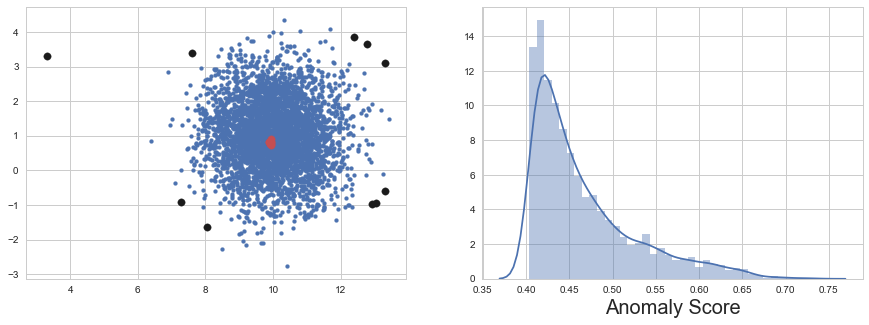

In [22]:
plt.rcParams['figure.figsize'] = (15, 5)
plt.figure()
plt.subplot(1,2,2)
p=sb.distplot(S4, kde=True, color="b")
plt.xlabel('Anomaly Score',fontsize=20)
plt.subplot(1,2,1)
ss=np.argsort(S4)
plt.scatter(x,y,s=15,c='b',edgecolor='b')
plt.scatter(x[ss[-10:]],y[ss[-10:]],s=55,c='k')
plt.scatter(x[ss[:10]],y[ss[:10]],s=55,c='r')

# [Case 5] 800 Trees in a single core, distribute the trees after training, and parallelize scoring in a vectorized way.  

In [23]:
ForestAssemblyTimes5 = []
ComputeScoreTimes5   = []

### train and score

In [24]:
for i in range(5):
    t1 = time.time()
    Forest5 = iso.iForest(X,ntrees=800, sample_size=256)
    trees = sc.parallelize(Forest5.Trees)
    t2 = time.time()
    ForestAssemblyTimes5.append(t2-t1)
    
    t1 = time.time()
    S_temp = trees.map(lambda t: 2.0**(iso.PathFactor2(X, t).paths*(-1.0)/Forest5.ntrees/Forest5.c))# this is an array (maybe np array) of 2^(-h/(F.ntrees*F.C))
    S5 = S_temp.reduce(lambda a,b: a*b) # Note that reduce is a multiplication operator
    t2 = time.time()
    ComputeScoreTimes5.append(t2-t1)

In [25]:
print("assembly mean: ",np.mean(ForestAssemblyTimes5))
print("assembly var: " ,np.var(ForestAssemblyTimes5))
print ("="*40)
print("score mean: ",np.mean(ComputeScoreTimes5))
print("score var: " ,np.var(ComputeScoreTimes5))

('assembly mean: ', 5.746354341506958)
('assembly var: ', 0.16346489068171194)
('score mean: ', 37.827991580963136)
('score var: ', 3.1034363625896413)


### Visualize

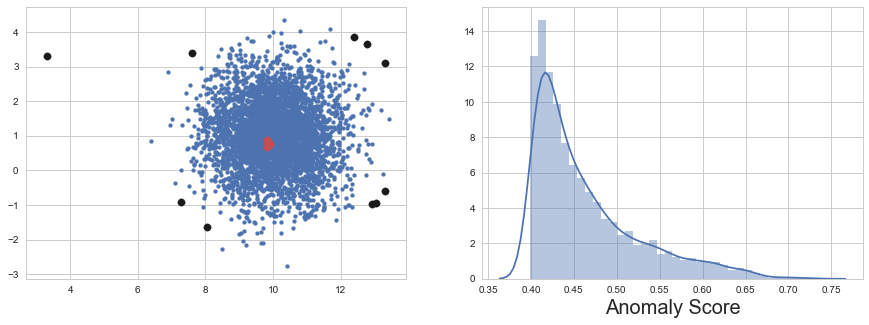

In [26]:
plt.rcParams['figure.figsize'] = (15, 5)
plt.figure()
plt.subplot(1,2,2)
p=sb.distplot(S5, kde=True, color="b")
plt.xlabel('Anomaly Score',fontsize=20)
plt.subplot(1,2,1)
ss=np.argsort(S5)
plt.scatter(x,y,s=15,c='b',edgecolor='b')
plt.scatter(x[ss[-10:]],y[ss[-10:]],s=55,c='k')
plt.scatter(x[ss[:10]],y[ss[:10]],s=55,c='r')

# [Case 6] Split the data for training among 8 cores. Each core has 100 trees. Split data for scoring.

In [27]:
ForestAssemblyTimes6 = []
ComputeScoreTimes6   = []

### Helper Functions

In [28]:
def partition(l,n):
 return [l[i:i+n] for i in xrange(0,len(l),n)]

### Create Forest(s)

In [29]:
for i in range(5):
    t1 = time.time()
    data = sc.parallelize(partition(X,len(X)/8))
    Forest6 = data.map(lambda x: (x,iso.iForest(x,ntrees=100, sample_size=256)))
    t2 = time.time()
    ForestAssemblyTimes6.append(t2-t1)
    
    t1 = time.time()
    S_t = Forest6.map(lambda x: x[1].compute_paths(x[0]))
    S6  = np.array(S_t.collect()).flatten()
    t2 = time.time()
    ComputeScoreTimes6.append(t2-t1)

In [30]:
print("assembly mean: ",np.mean(ForestAssemblyTimes6))
print("assembly var: " ,np.var(ForestAssemblyTimes6))
print ("="*40)
print("score mean: ",np.mean(ComputeScoreTimes6))
print("score var: " ,np.var(ComputeScoreTimes6))

('assembly mean: ', 0.0060789585113525391)
('assembly var: ', 1.5287415635611978e-06)
('score mean: ', 2.5974838256835939)
('score var: ', 0.0092896965265117613)


### Visualize

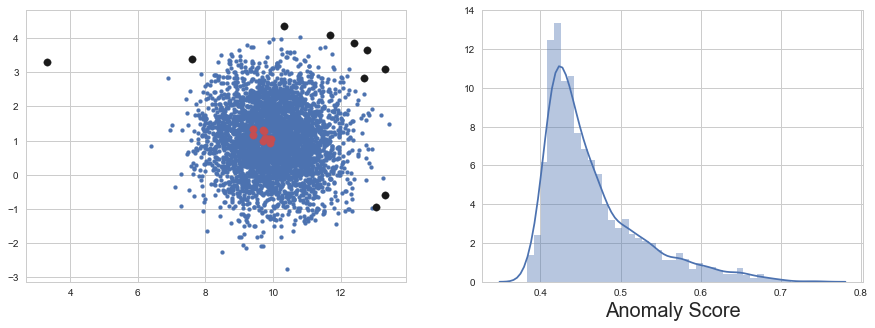

In [31]:
plt.rcParams['figure.figsize'] = (15, 5)
plt.figure()
plt.subplot(1,2,2)
p=sb.distplot(S6, kde=True, color="b")
plt.xlabel('Anomaly Score',fontsize=20)
plt.subplot(1,2,1)
ss=np.argsort(S6)
plt.scatter(x,y,s=15,c='b',edgecolor='b')
plt.scatter(x[ss[-10:]],y[ss[-10:]],s=55,c='k')
plt.scatter(x[ss[:10]],y[ss[:10]],s=55,c='r')

# [Case 7] Create 800 trees in a single core

In [32]:
ForestAssemblyTimes7 = []
ComputeScoreTimes7   = []

### Train and Score

In [33]:
for i in range(5):
    t1 = time.time()
    Forest7 = iso.iForest(X,ntrees=800, sample_size=256)
    t2 = time.time()
    ForestAssemblyTimes7.append(t2-t1)
    
    t1 = time.time()
    S7 = Forest7.compute_paths(X)
    t2 = time.time()
    ComputeScoreTimes7.append(t2-t1)

In [34]:
print("assembly mean: ",np.mean(ForestAssemblyTimes7))
print("assembly var: " ,np.var(ForestAssemblyTimes7))
print ("="*40)
print("score mean: ",np.mean(ComputeScoreTimes7))
print("score var: " ,np.var(ComputeScoreTimes7))

('assembly mean: ', 2.85596022605896)
('assembly var: ', 0.10668363392002447)
('score mean: ', 61.287877845764157)
('score var: ', 0.55136457024444552)


### Visualize

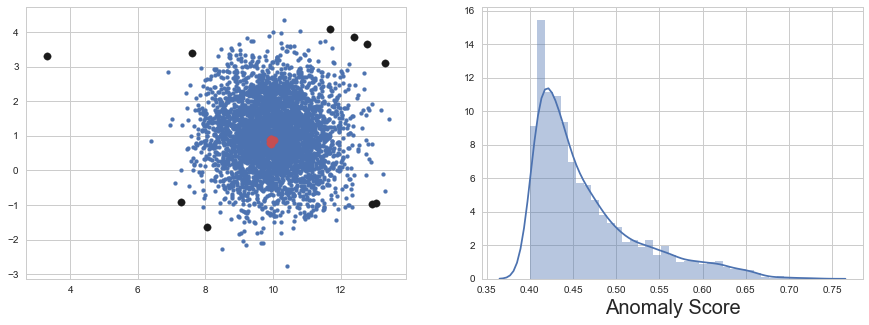

In [35]:
plt.rcParams['figure.figsize'] = (15, 5)
plt.figure()
plt.subplot(1,2,2)
p=sb.distplot(S1, kde=True, color="b")
plt.xlabel('Anomaly Score',fontsize=20)
plt.subplot(1,2,1)
ss=np.argsort(S1)
plt.scatter(x,y,s=15,c='b',edgecolor='b')
plt.scatter(x[ss[-10:]],y[ss[-10:]],s=55,c='k')
plt.scatter(x[ss[:10]],y[ss[:10]],s=55,c='r')

# Statistics

In [61]:
trainingMeans = map(lambda x: np.mean(x), [ForestAssemblyTimes1,ForestAssemblyTimes2,ForestAssemblyTimes3,ForestAssemblyTimes4,ForestAssemblyTimes5,ForestAssemblyTimes6])

In [62]:
trainingVar = map(lambda x: np.var(x), [ForestAssemblyTimes1,ForestAssemblyTimes2,ForestAssemblyTimes3,ForestAssemblyTimes4,ForestAssemblyTimes5,ForestAssemblyTimes6])

In [63]:
scoringMean = map(lambda x: np.mean(x), [ComputeScoreTimes1,ComputeScoreTimes2,ComputeScoreTimes3,ComputeScoreTimes4,ComputeScoreTimes5,ComputeScoreTimes6])

In [64]:
scoringVar = map(lambda x: np.var(x), [ComputeScoreTimes1,ComputeScoreTimes2,ComputeScoreTimes3,ComputeScoreTimes4,ComputeScoreTimes5,ComputeScoreTimes6])

In [65]:
totalMean = np.array(trainingMeans)+np.array(scoringMean)
totalVar  = np.array(trainingVar)+np.array(scoringVar)

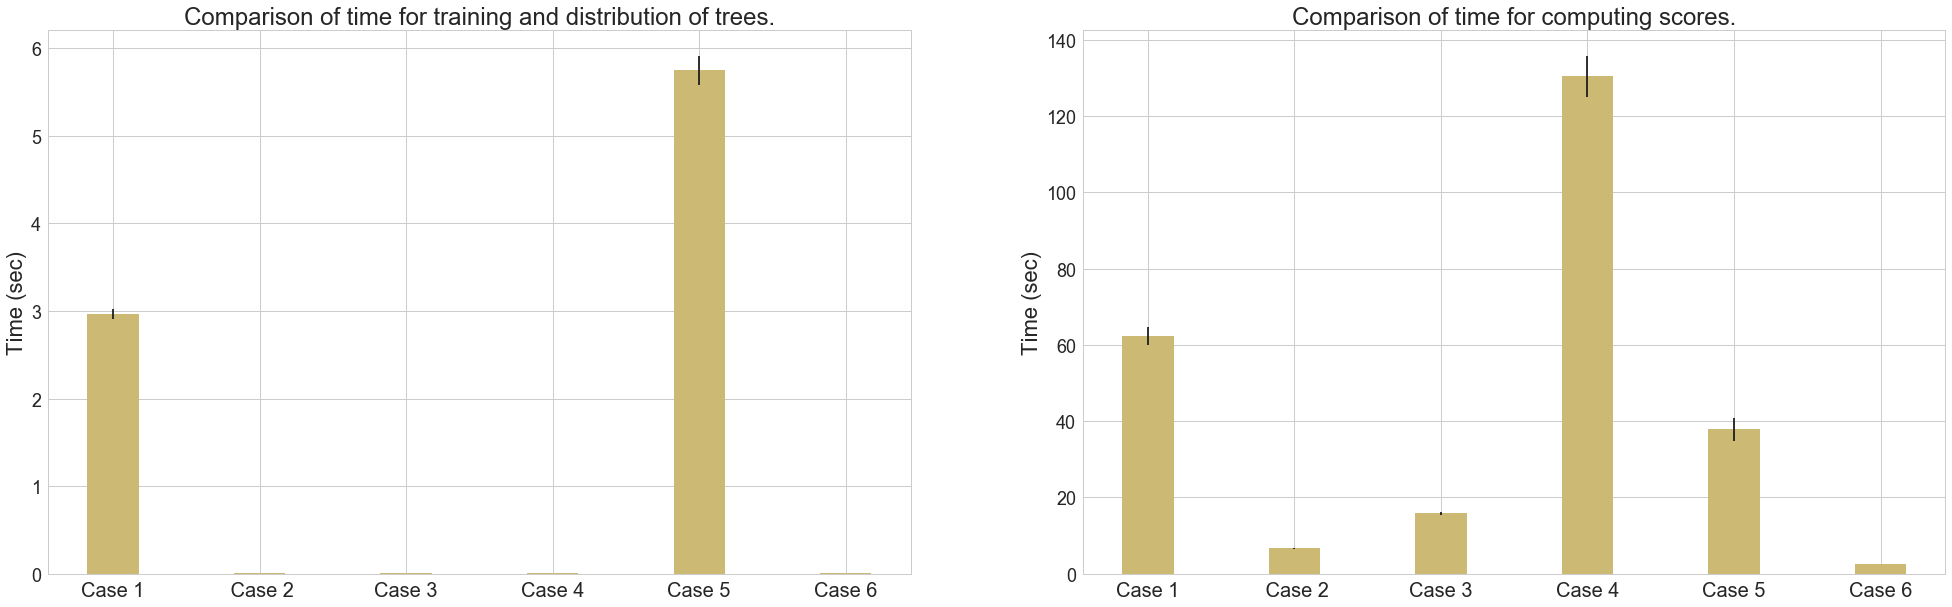

In [66]:
plt.rcParams['figure.figsize'] = (34, 10)
ind = np.arange(len(trainingMeans))  # the x locations for the groups
width = 0.35       # the width of the bars

plt.figure(1)
ax1 = plt.subplot(1,2,1)
rects1 = plt.bar(ind, trainingMeans, width, color='y', yerr=trainingVar)

# add some text for labels, title and axes ticks
ax1.set_ylabel('Time (sec)',fontsize=22)
ax1.set_title('Comparison of time for training and distribution of trees.',fontsize=24)
ax1.set_xticks(ind )
ax1.set_xticklabels(('Case 1', ' Case 2', 'Case 3', 'Case 4', 'Case 5', 'Case 6'),fontsize=20)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(18)  

ax2=plt.subplot(1,2,2)
rects2 = plt.bar(ind, scoringMean, width, color='y', yerr=scoringVar)
ax2.set_ylabel('Time (sec)',fontsize=22)
ax2.set_title('Comparison of time for computing scores.',fontsize=24)
ax2.set_xticks(ind )
ax2.set_xticklabels(('Case 1', ' Case 2', 'Case 3', 'Case 4', 'Case 5', 'Case 6'),fontsize=20)
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(18)  

plt.savefig("/Users/sahand/Research/iso_forest/report/images/TimeComparison.png",bbox_inches='tight')

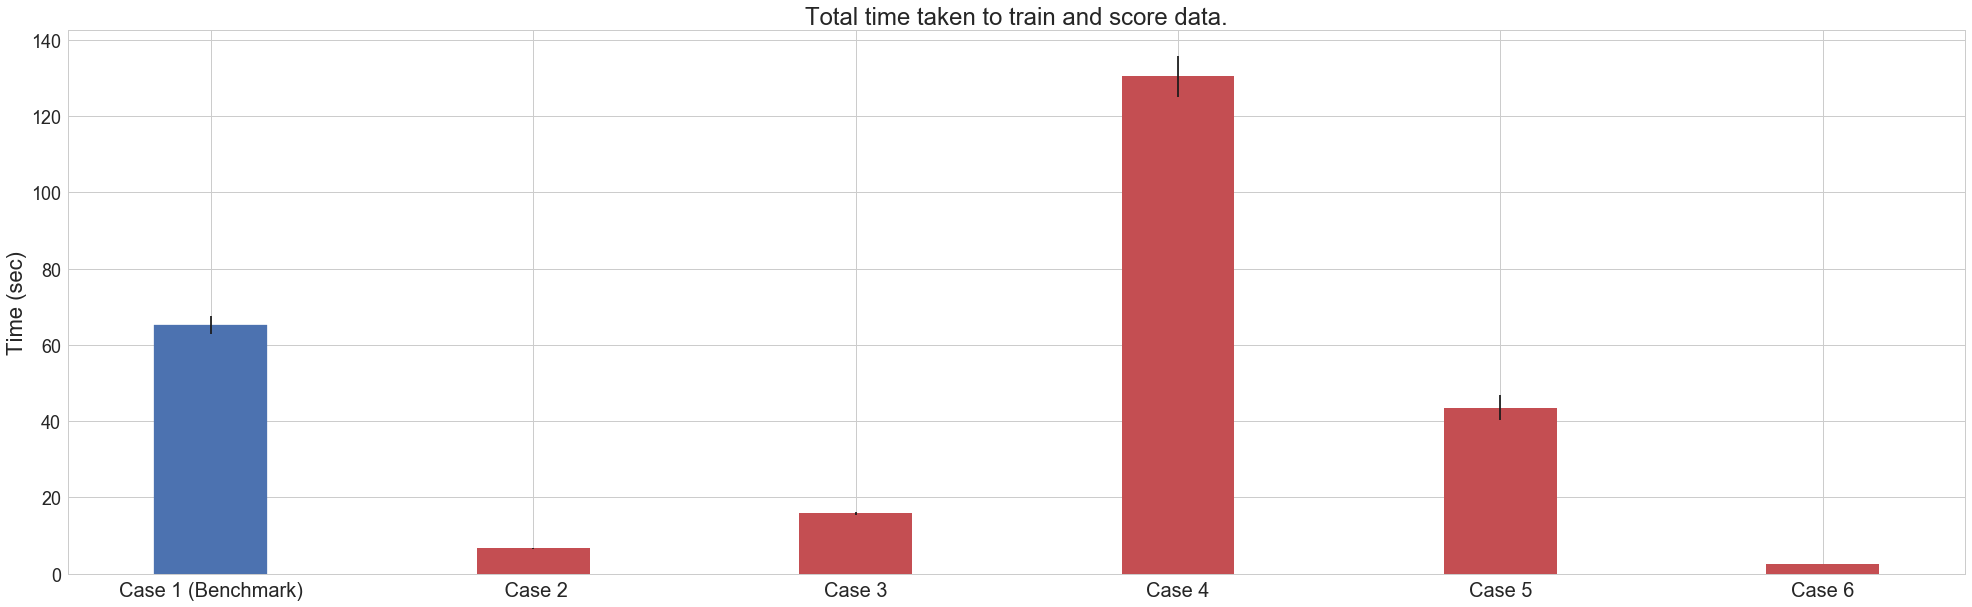

In [67]:
ax3=plt.subplot(1,1,1)
rects3 = plt.bar(ind, totalMean, width, color='r', yerr=totalVar)
ax3.set_ylabel('Time (sec)',fontsize=22)
ax3.set_title('Total time taken to train and score data.',fontsize=24)
ax3.set_xticks(ind)
ax3.set_xticklabels(('Case 1 (Benchmark)', ' Case 2', 'Case 3', 'Case 4', 'Case 5', 'Case 6'),fontsize=20)
for tick in ax3.yaxis.get_major_ticks():
    tick.label.set_fontsize(18)  
rects3[0].set_color('b')
plt.savefig("/Users/sahand/Research/iso_forest/report/images/TimeComparisonTotal.png",bbox_inches='tight')

+ Use the serial case as the benchmark
+ Use a metric: Look at the anomoly scores for each case and look at the difference between each case and the benchmark (disance^2)
+ We want the case that is fastest and closest to the benchmark case. 

In [68]:
ss  = np.argsort(S1)
Sb  = S1[ss]
S2s = S2[ss]
S3s = S3[ss]
S4s = S4[ss]
S5s = S5[ss]
S6s = S6[ss]
S7s = S7[ss]
Ss = [S7s,S2s,S3s,S4s,S5s,S6s]

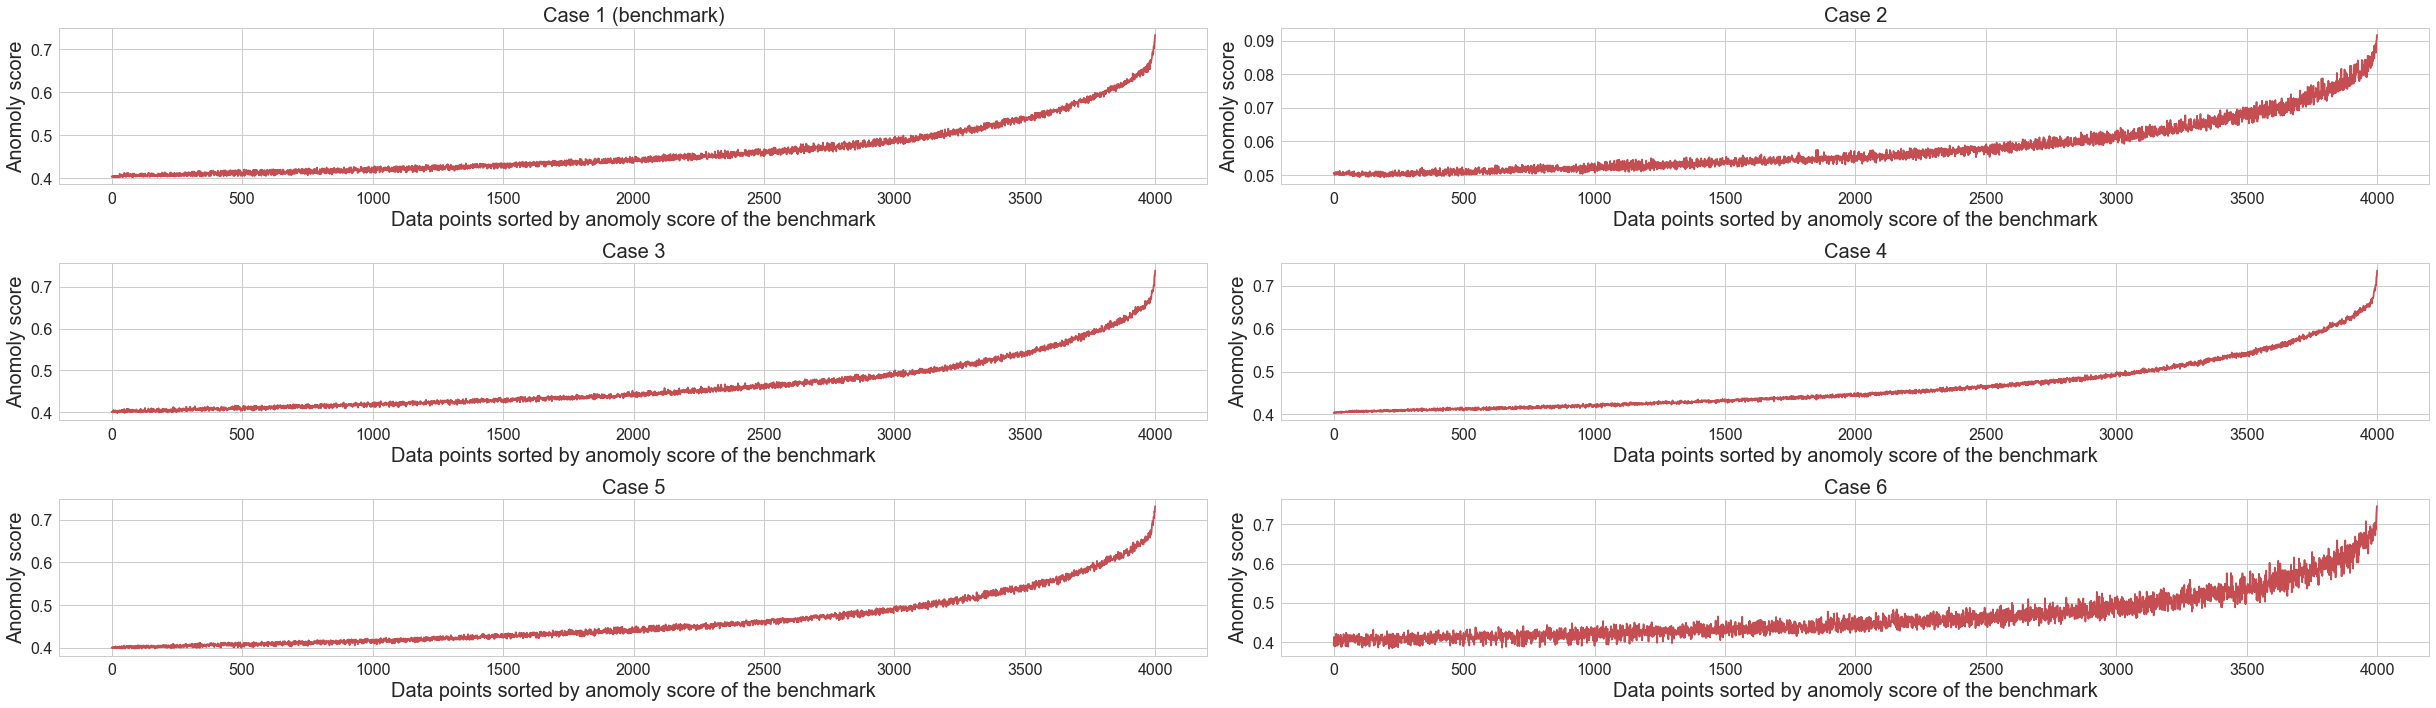

In [69]:
plt.rcParams['figure.figsize'] = (34, 10)

for i in range(len(Ss)):
    ax1=plt.subplot(3,2,i+1)
    plt.plot(Ss[i],'r')
    plt.xlabel('Data points sorted by anomoly score of the benchmark',fontsize=20)
    plt.ylabel('Anomoly score',fontsize=20)
    if i == 0:
        plt.title('Case 1 (benchmark)',fontsize=20)
    else:
        plt.title('Case {}'.format(i+1),fontsize=20)
    plt.tight_layout()
    for tick in ax1.yaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    for tick in ax1.xaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    
plt.savefig("/Users/sahand/Research/iso_forest/report/images/SortedAnomolyScore.png",bbox_inches='tight')

In [70]:
diffs = map(lambda x:(100*(x-Sb)/Sb)**2,Ss)

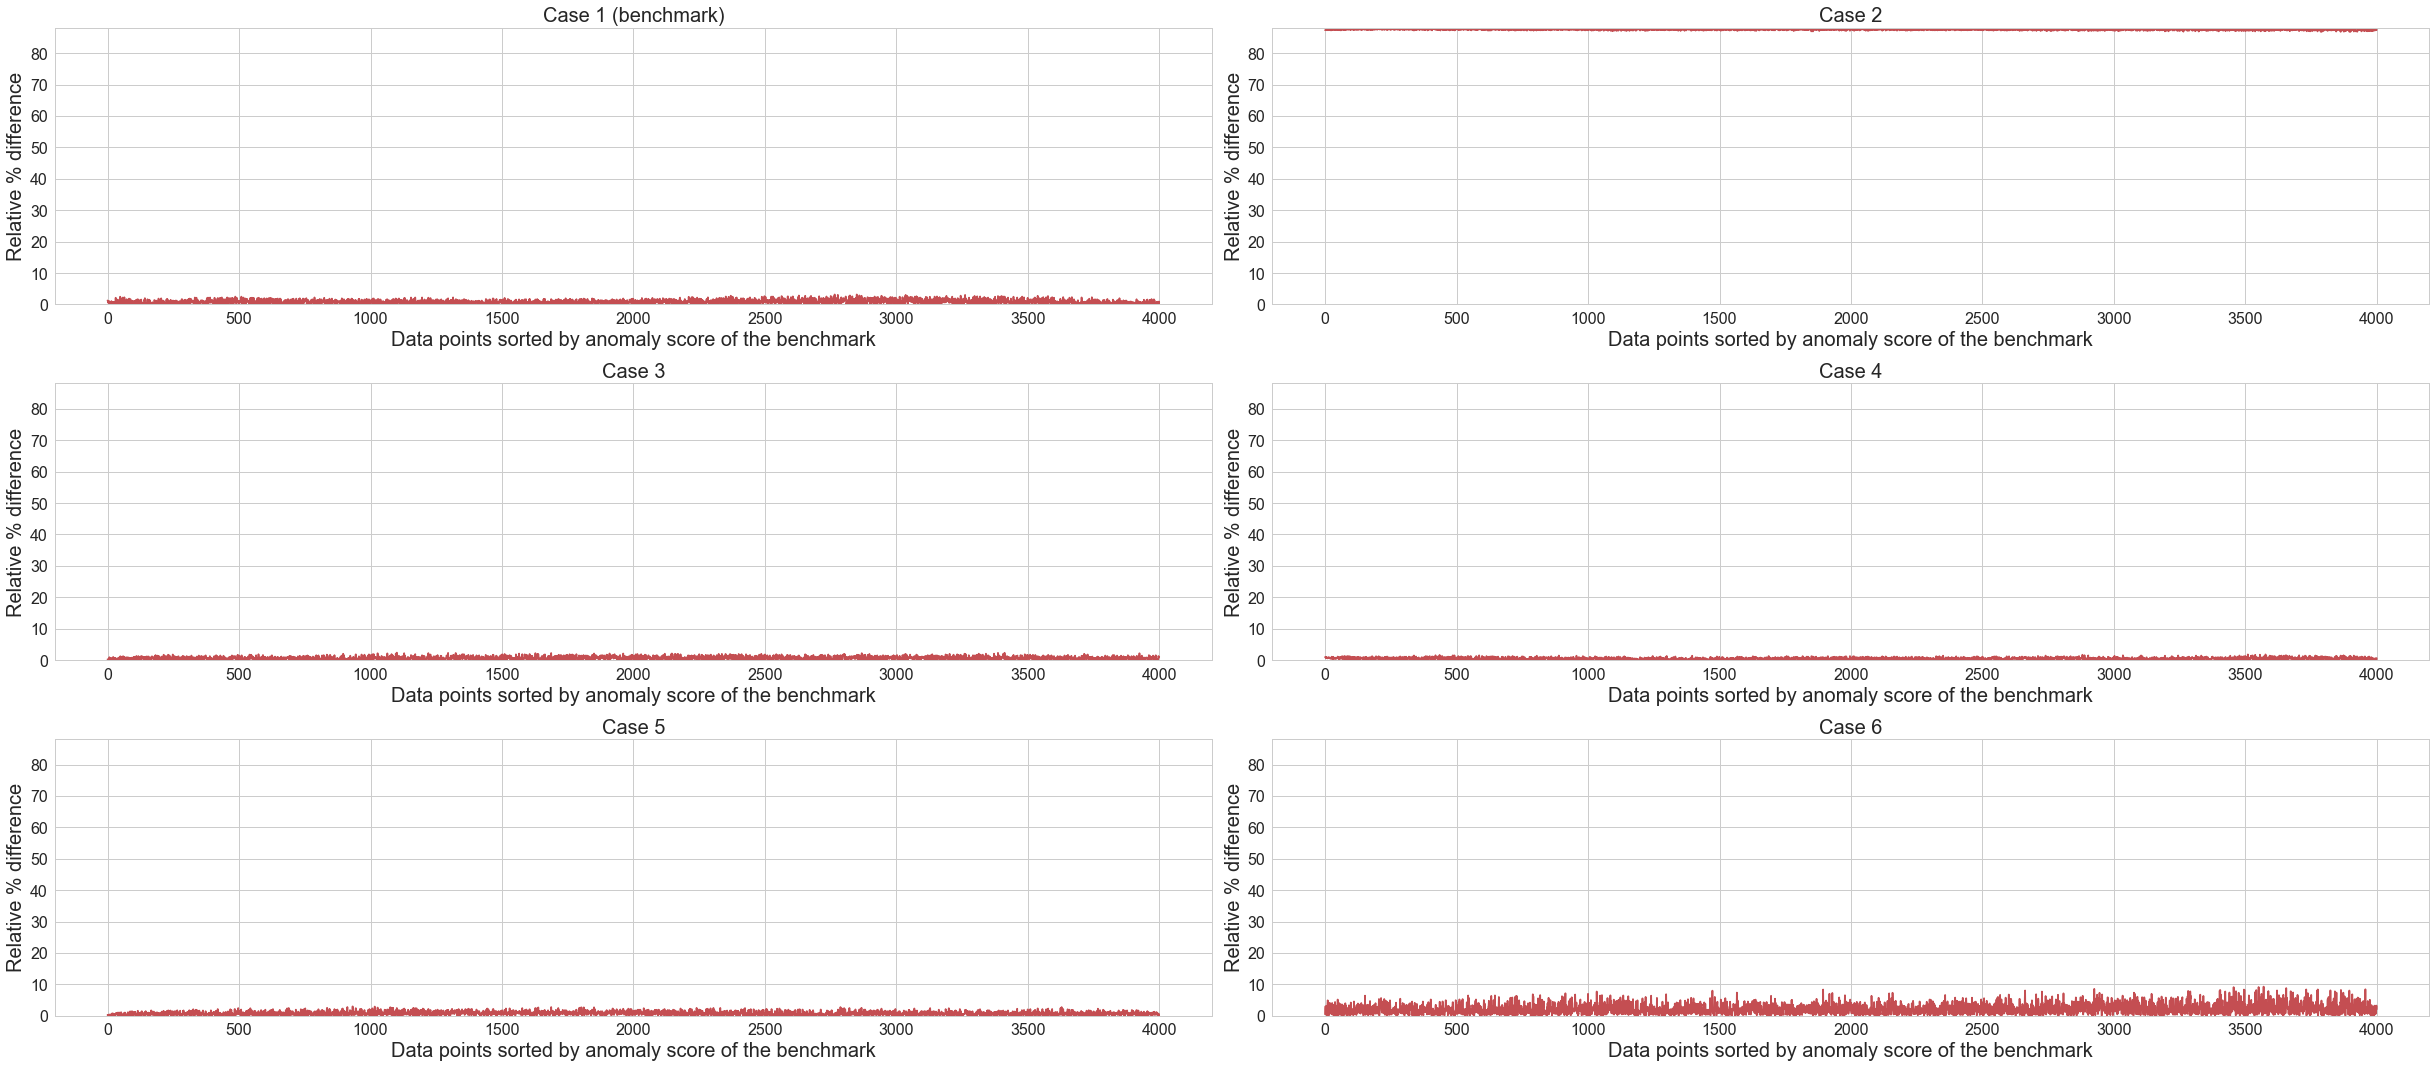

In [71]:
plt.rcParams['figure.figsize'] = (34, 15)
ylim = np.sqrt(max(map(max,diffs)))
for i in range(len(diffs)):
    ax1 = plt.subplot(3,2,i+1)
    plt.plot(range(len(diffs[i])),np.sqrt(diffs[i]),'r')
    plt.xlabel('Data points sorted by anomaly score of the benchmark',fontsize=20)
    plt.ylabel('Relative % difference',fontsize=20)
    if i == 0:
        plt.title('Case 1 (benchmark)',fontsize=20)
    else:
        plt.title('Case {}'.format(i+1),fontsize=20)
    for tick in ax1.yaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    for tick in ax1.xaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    plt.tight_layout()
    plt.ylim([0,ylim])
plt.savefig("/Users/sahand/Research/iso_forest/report/images/SortedAnomolyScoreDiff.png",bbox_inches='tight')

In [72]:
def getRMS(data):
    return np.sqrt(np.sum(data))/len(data)

In [73]:
data = map(getRMS,diffs)

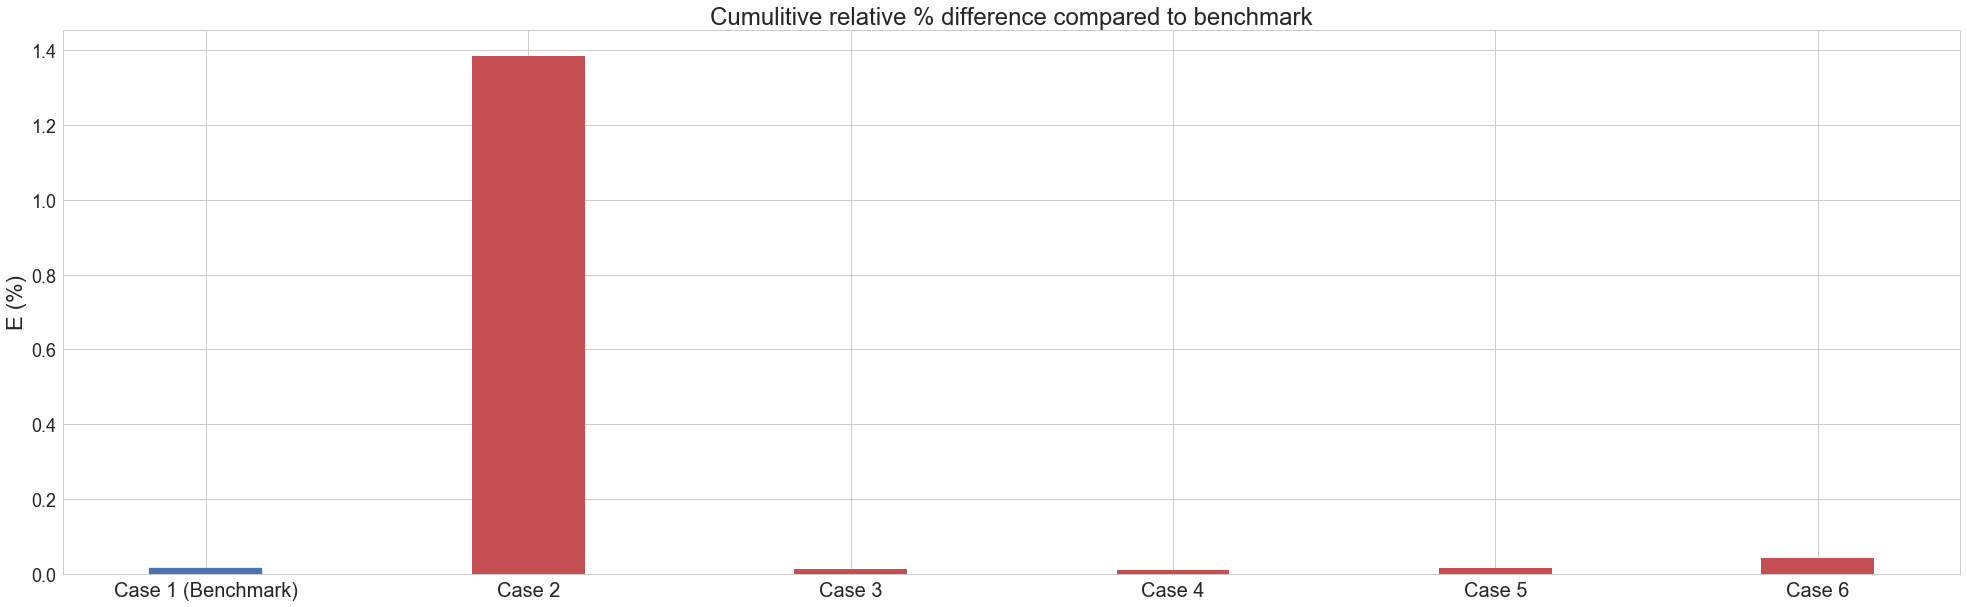

In [74]:
plt.rcParams['figure.figsize'] = (34, 10)
ind = np.arange(len(data))  # the x locations for the groups
width = 0.35       # the width of the bars

plt.figure(1)
ax1 = plt.subplot(1,1,1)
rects1 = plt.bar(ind, data, width, color='r')

# add some text for labels, title and axes ticks
ax1.set_ylabel('E (%)',fontsize=22)
ax1.set_title('Cumulitive relative % difference compared to benchmark',fontsize=24)
ax1.set_xticks(ind )
ax1.set_xticklabels(('Case 1 (Benchmark)','Case 2','Case 3','Case 4','Case 5', 'Case 6'),fontsize=20)
rects1[0].set_color('b')
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(18)  
plt.savefig("/Users/sahand/Research/iso_forest/report/images/rmsdiff.png",bbox_inches='tight')


In [93]:
np.sum(np.sin(np.linspace(1,1e7,1e7)))

/Users/sahand/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


1.9558914085413672